In [141]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
sns.set_context('poster',font_scale=1.4)
import pandas as pd
import pyccl as ccl
from itertools import chain
from pprint import pprint
from math import fsum
import firecrown as fc

Populating the interactive namespace from numpy and matplotlib


Make a photo-z model like this:

lens sample: 10 redshift bins spaced by 0.1 from 0.2 to 1.2
source sample: 5 redshift bins defined with equal numbers of source galaxies per bins
$$ \frac{dN}{dz} = z^2 exp (- (\frac{z}{z_0})^\alpha) $$
with $$z_0 = 0.28$$ and $$\alpha = 0.9$$
and bias $$ b(z) = 0.95/G(z)$$ and scatter $$ \sigma_z = 0.03 (1+z) $$

# Creating Photo-z Distributions

## Source galaxy distribution

### Creating 5 bins with equal number of source galaxies

In [9]:
# getting the n(z) distribution from the LSSTDESC/Requirements github repo for Y10 and i+r bands. 
# only using this for source galaxy binning.

df = pd.read_csv('nzdist.txt', sep=' ') 
df.head()

,zmid,dn,dneff
0,0.05,0.107288,0.101795
1,0.15,0.600815,0.497371
2,0.25,1.233816,0.946778
3,0.35,2.521276,1.889779
4,0.45,3.350079,2.331543


In [29]:
zmid = df['zmid']
dneff = df['dneff']

# turn zmid, dneff pairs into a histogrammable dataset.
datapts = ([list(np.ones(int(dneff[i]/min(dneff)))*zmid[i]) for i in range(len(zmid))])
datapts = list(chain.from_iterable(datapts)) # flatten

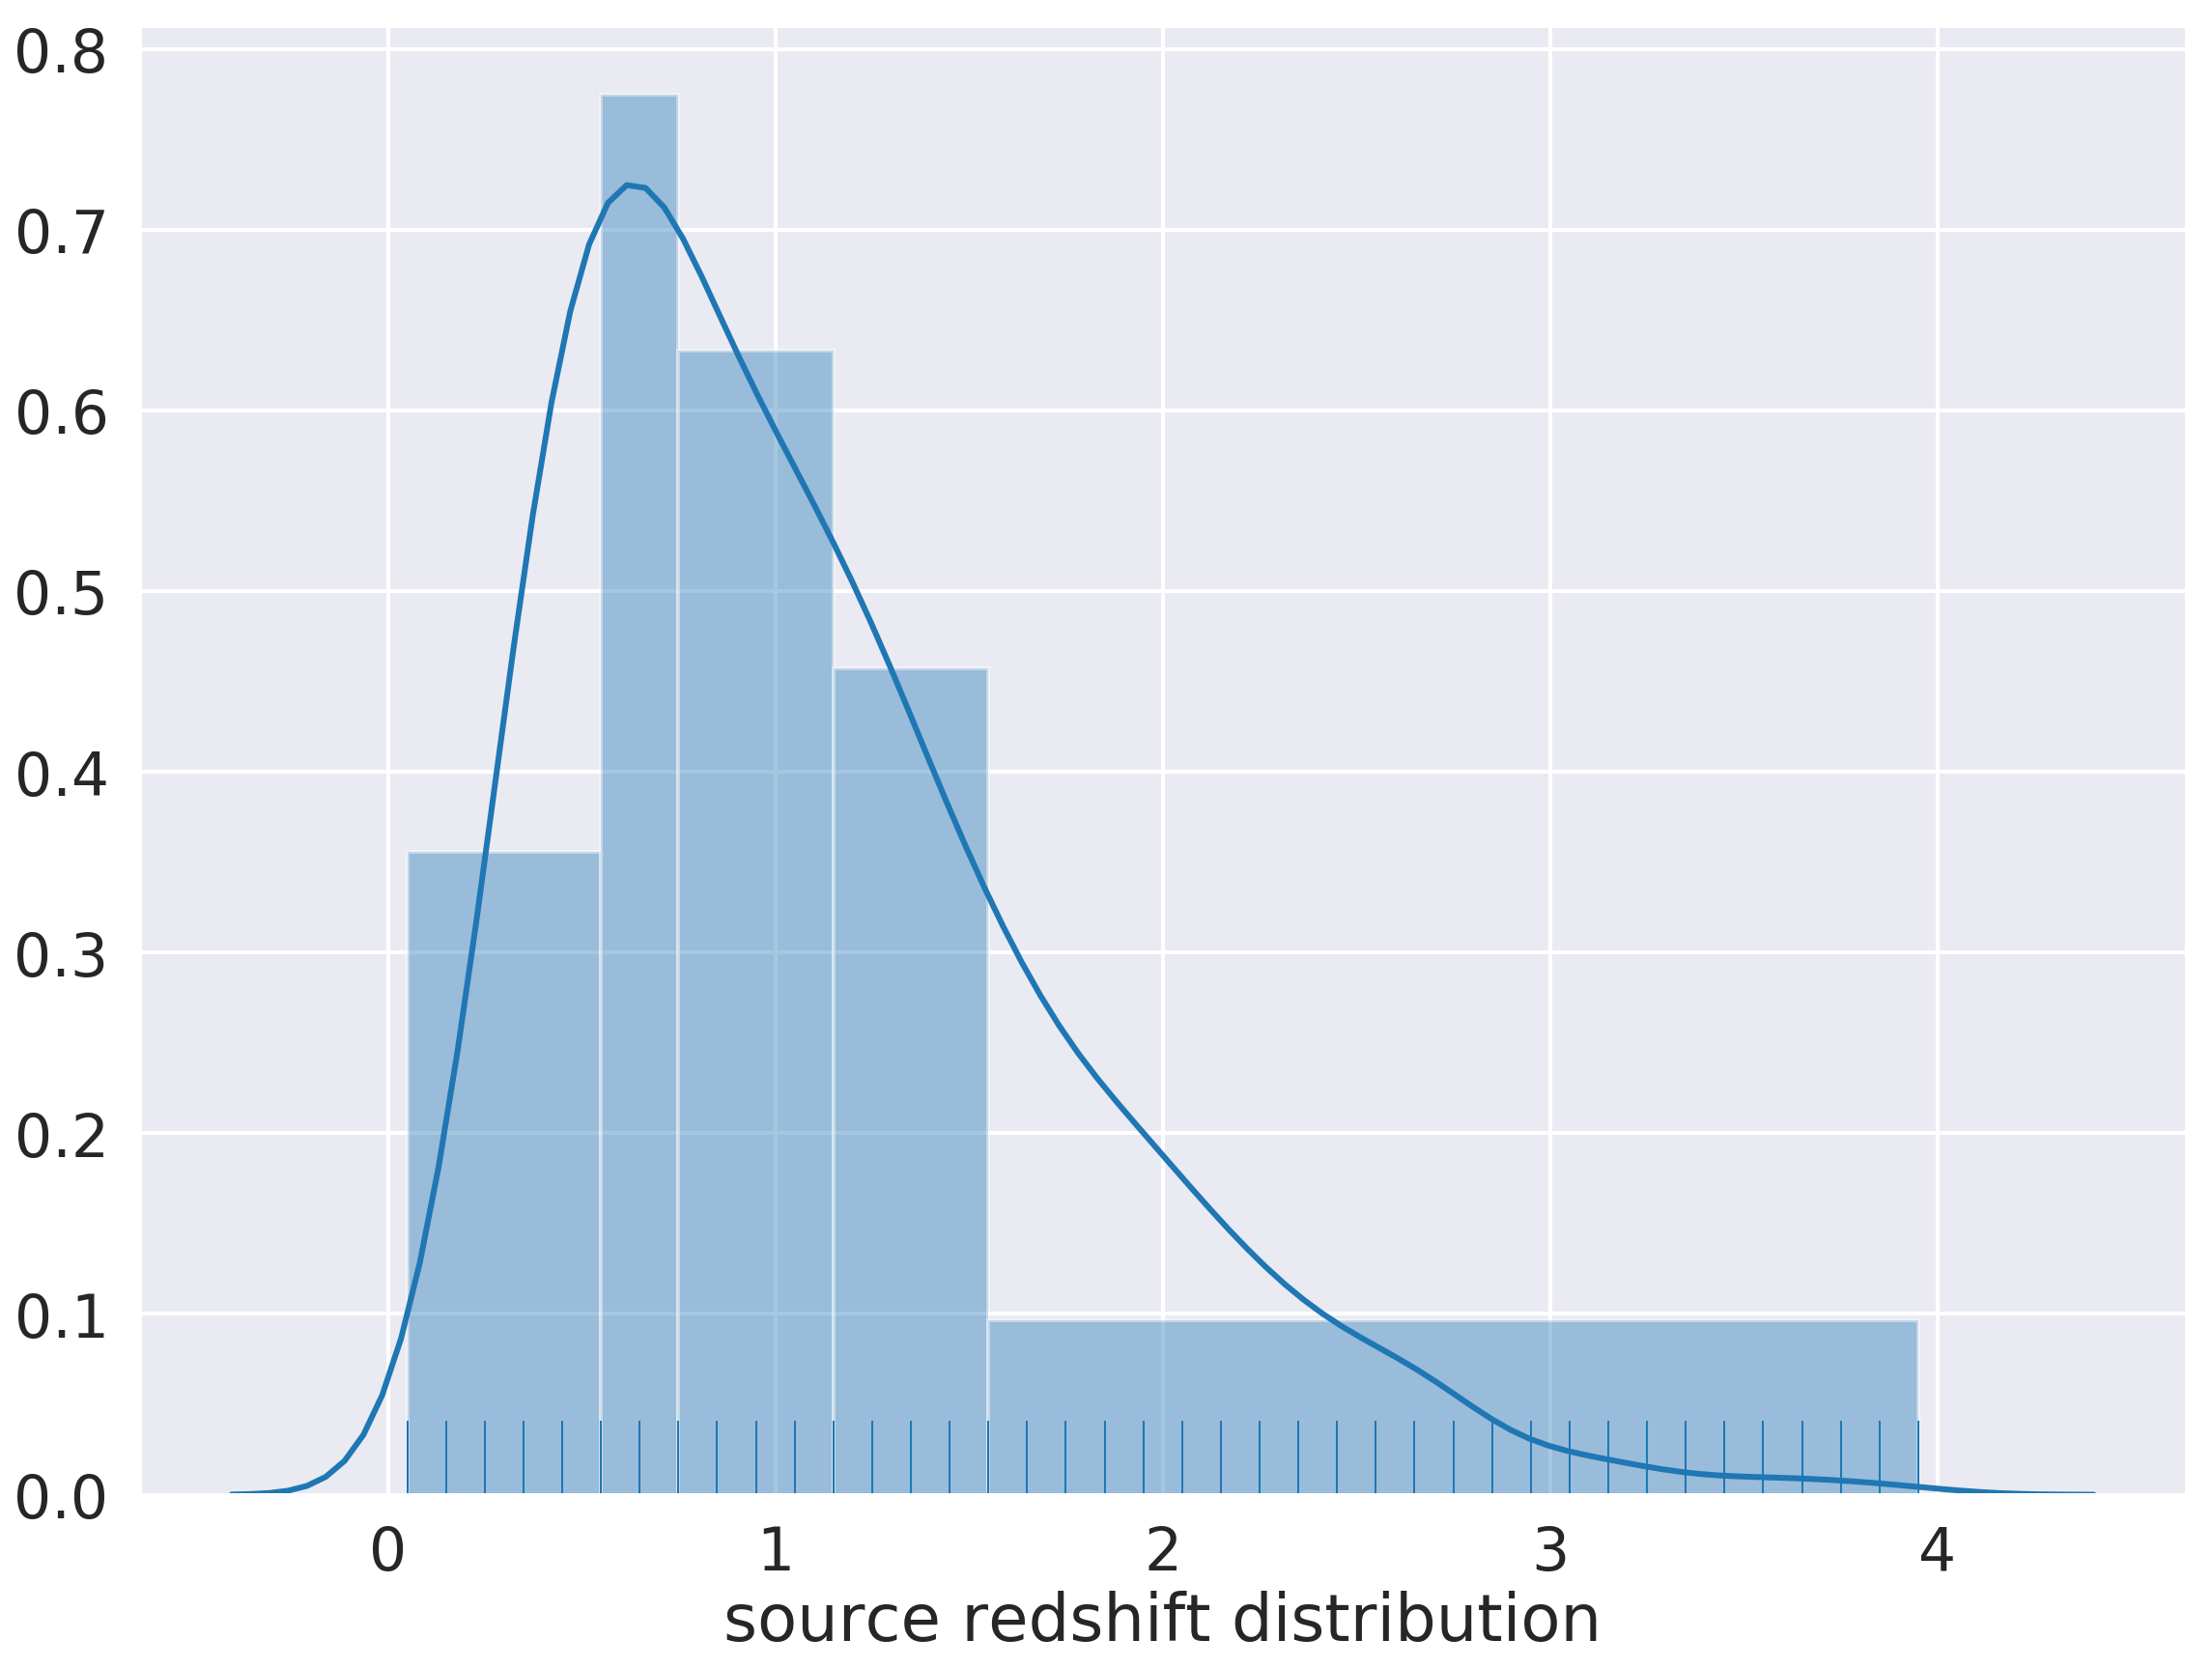

In [113]:
bins = datapts[0::int(len(datapts)/5)] # bin edges
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('source redshift distribution');

In [125]:
bin_centers = [.5*fsum([bins[i]+bins[i+1]]) for i in range(len(bins[:-1]))]

### Create source dN/dz distribution

In [126]:
pz = ccl.PhotoZGaussian(0.05) # creates 0.05 (1+z) Gaussian PZ function
z = np.linspace(0, 4, 121)
dNdz_dict_source = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_source[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

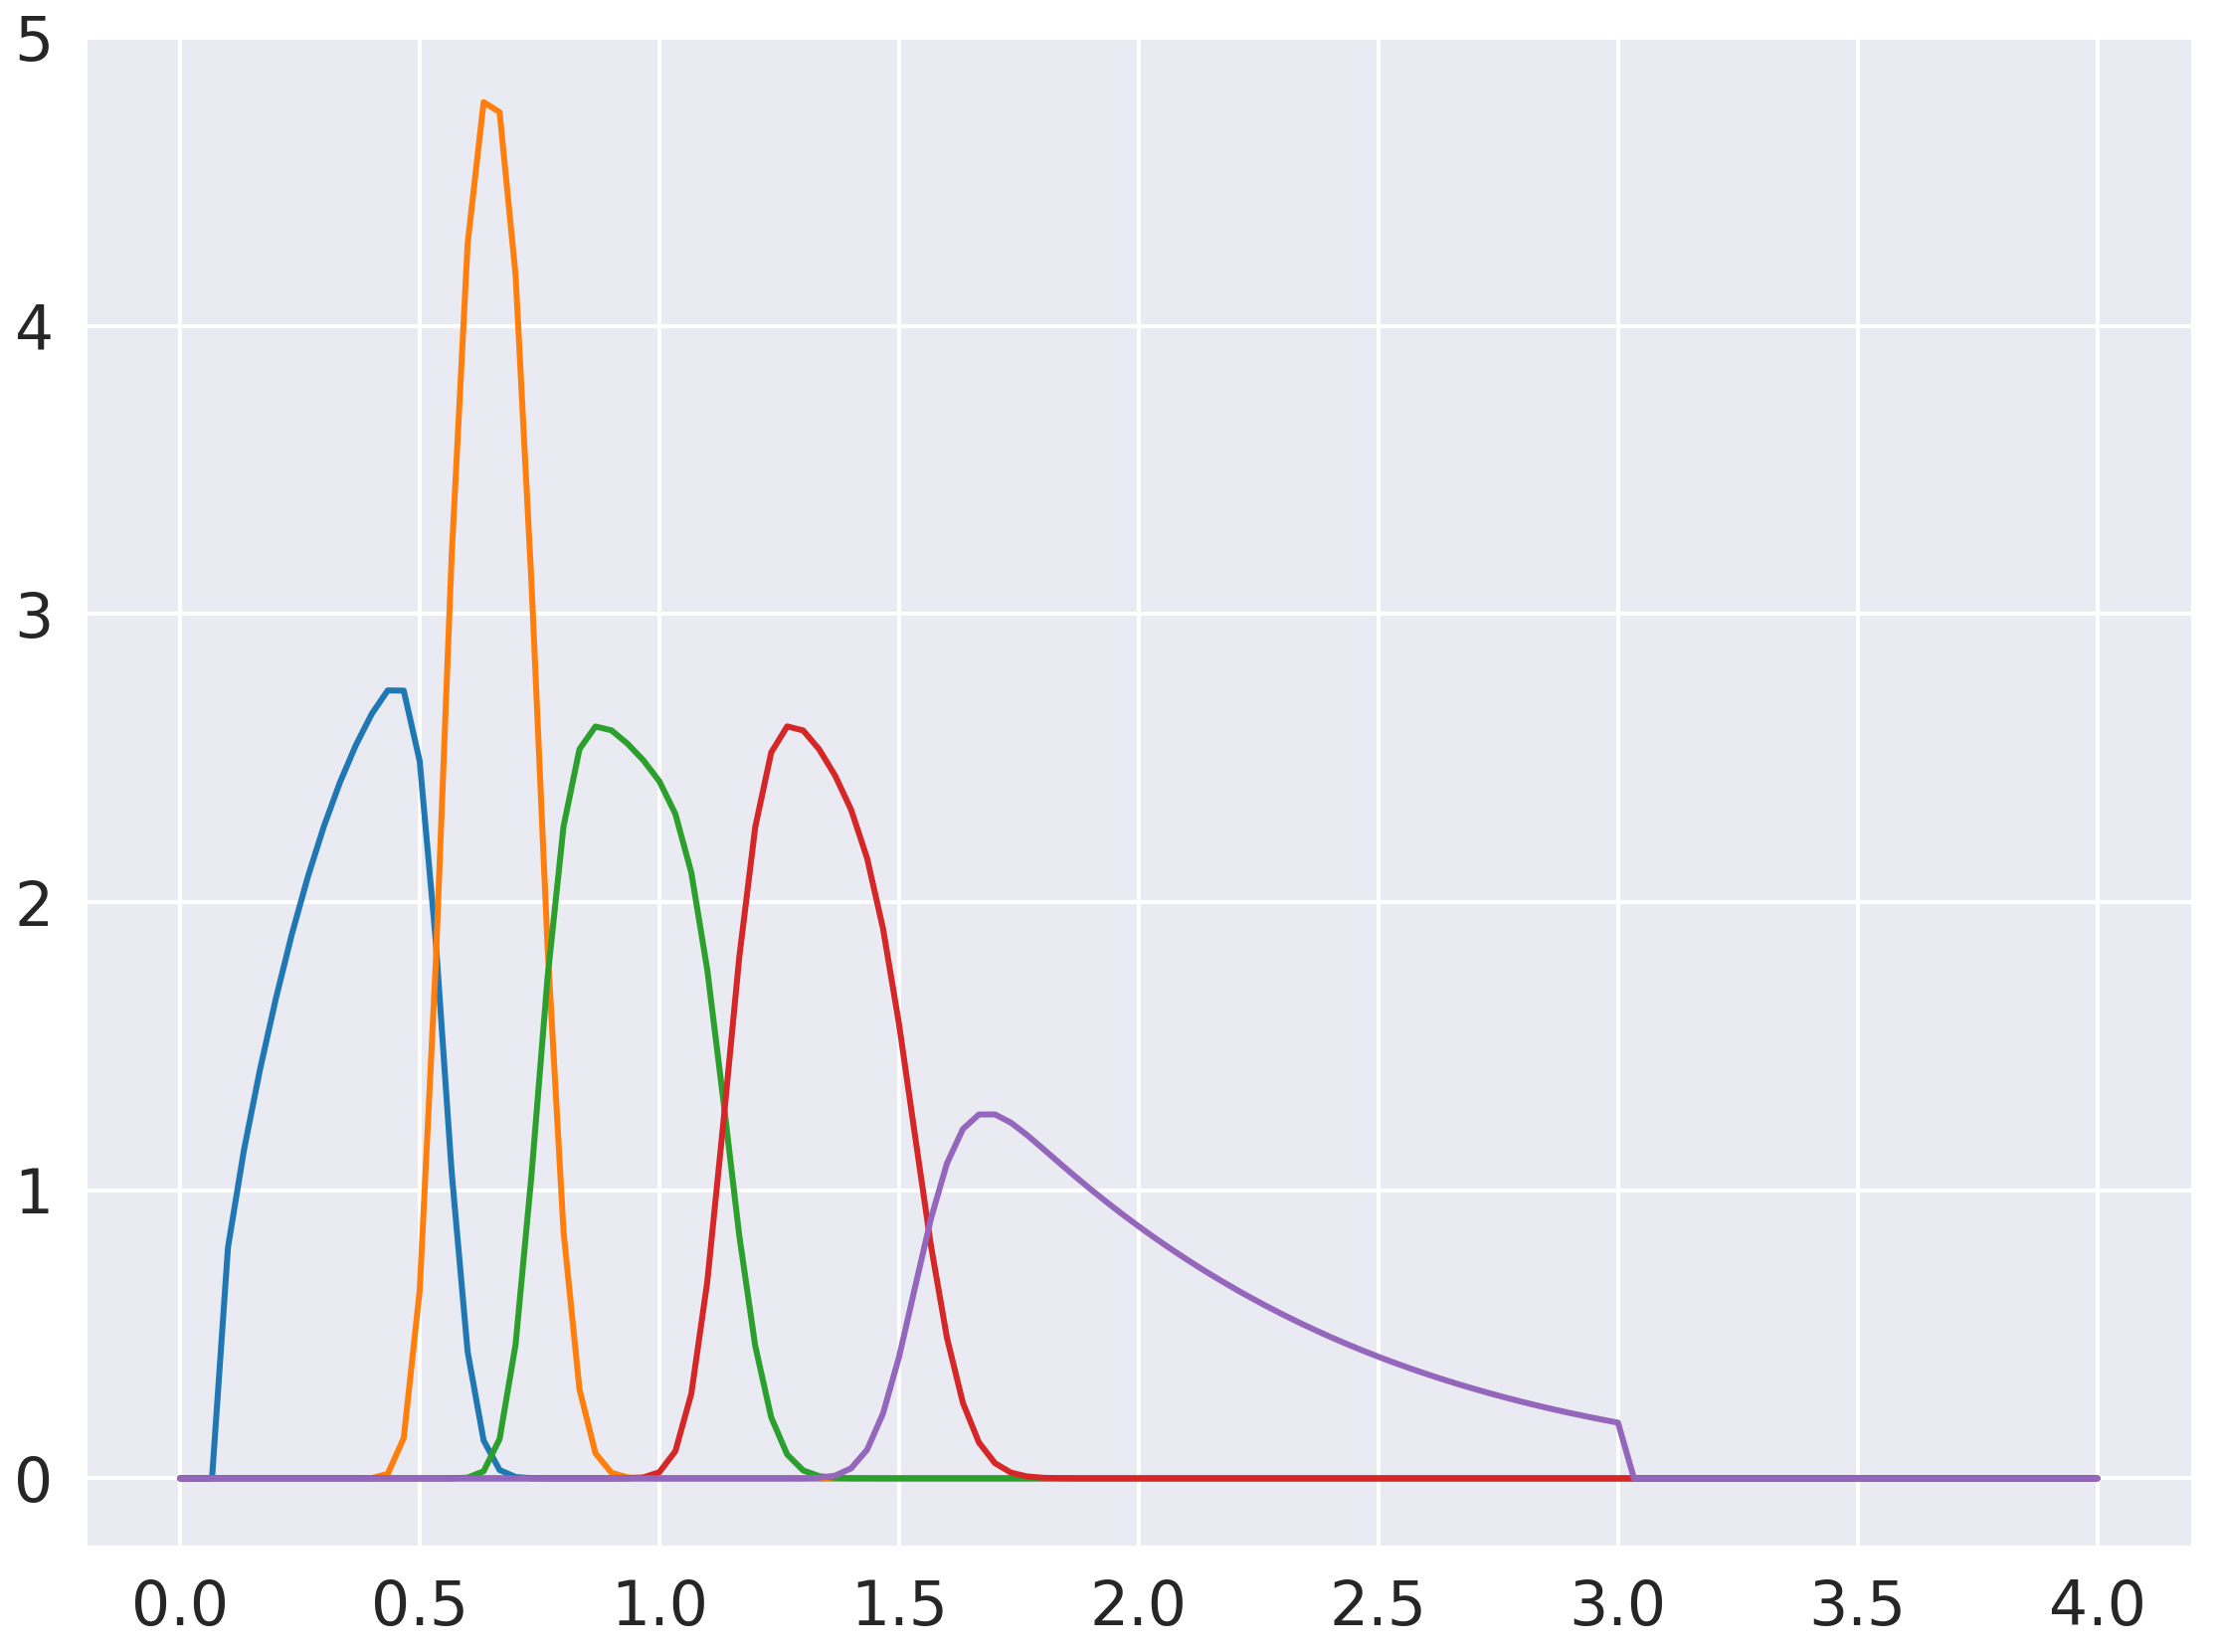

In [74]:
for key in dNdz_dict.keys():
    sns.lineplot(z, dNdz_dict[key], markers=False)

## Lens redshift distribution:

### Define bins

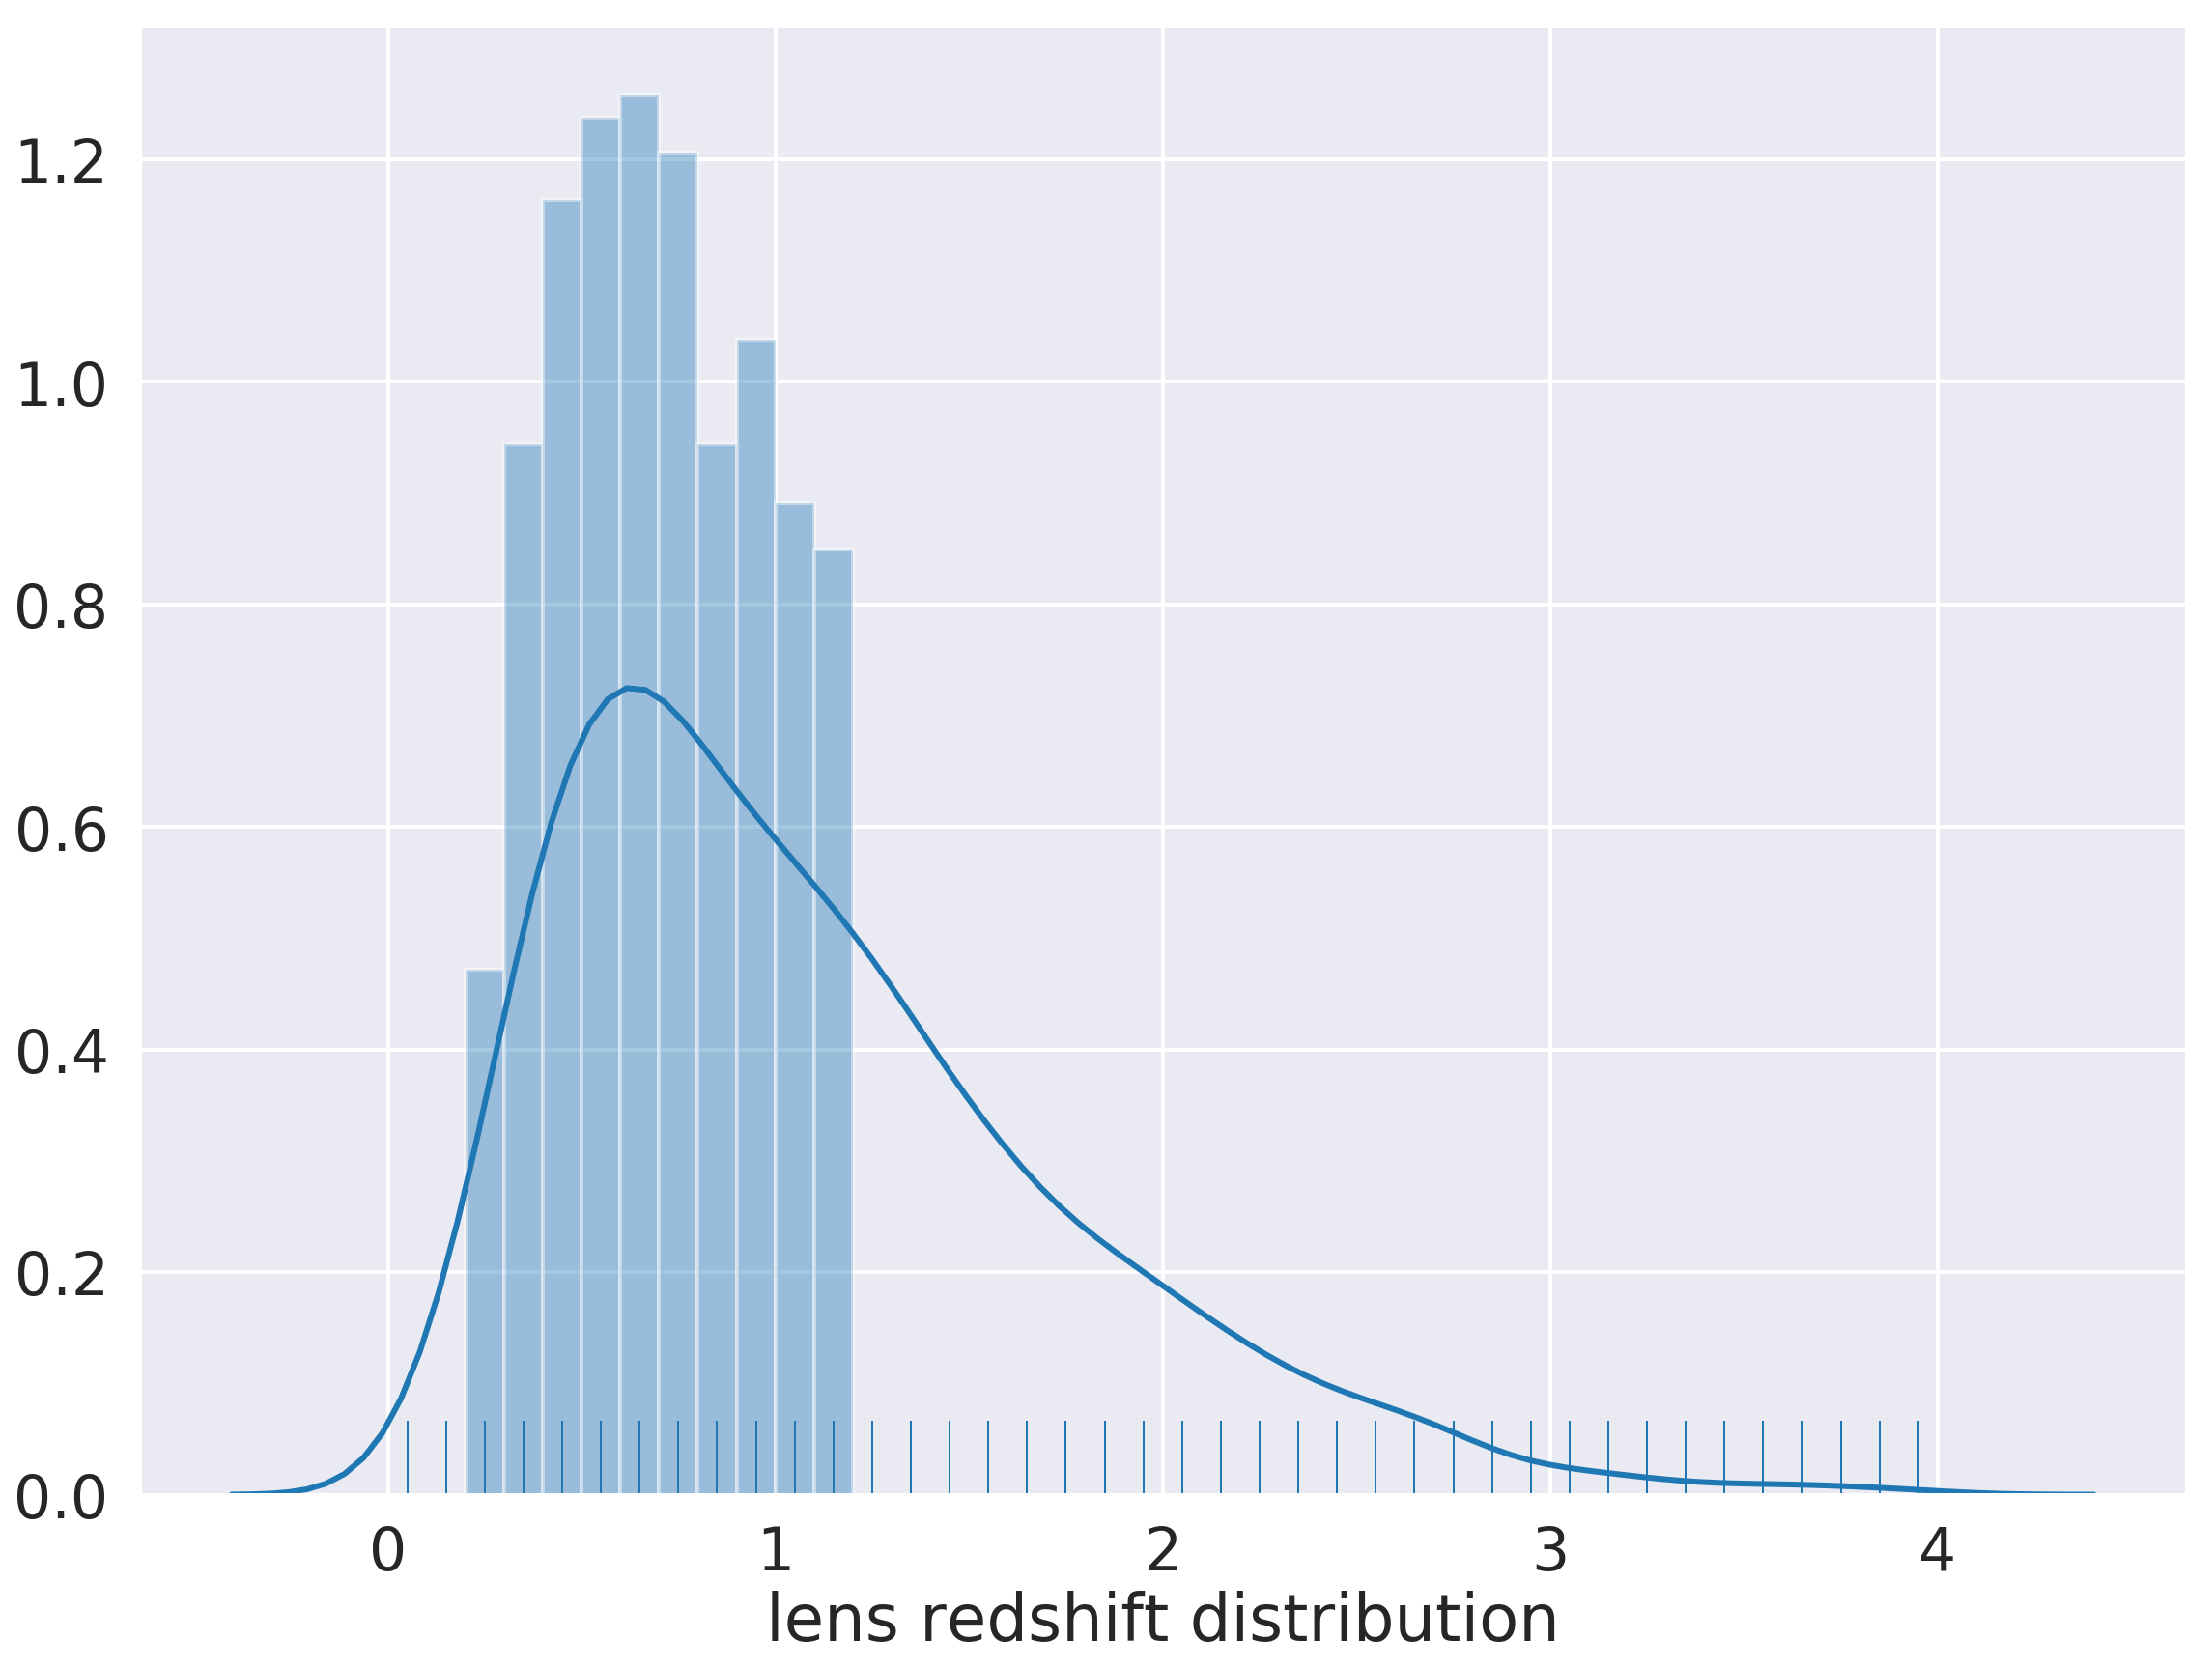

In [135]:
bins = np.linspace(0.2, 1.2, 11) # defines bin edges
bin_centers = [fsum([bin+0.1]) for bin in bins][:-1]
sns.distplot(datapts, bins=bins, rug=True);
plt.xlabel('lens redshift distribution');

### Creating Lens dN/dz distribution 

In [136]:
pz = ccl.PhotoZGaussian(0.03) # creates 0.03 (1+z) Gaussian PZ function
z = np.linspace(0, 4, 121)
dNdz_dict_lens = {}
for i, bin in enumerate(bins[:-1]):
    dNdz_dict_lens[bin_centers[i]] = ccl.dNdz_tomog(z, 'wl_fid', bins[i], bins[i+1], pz)

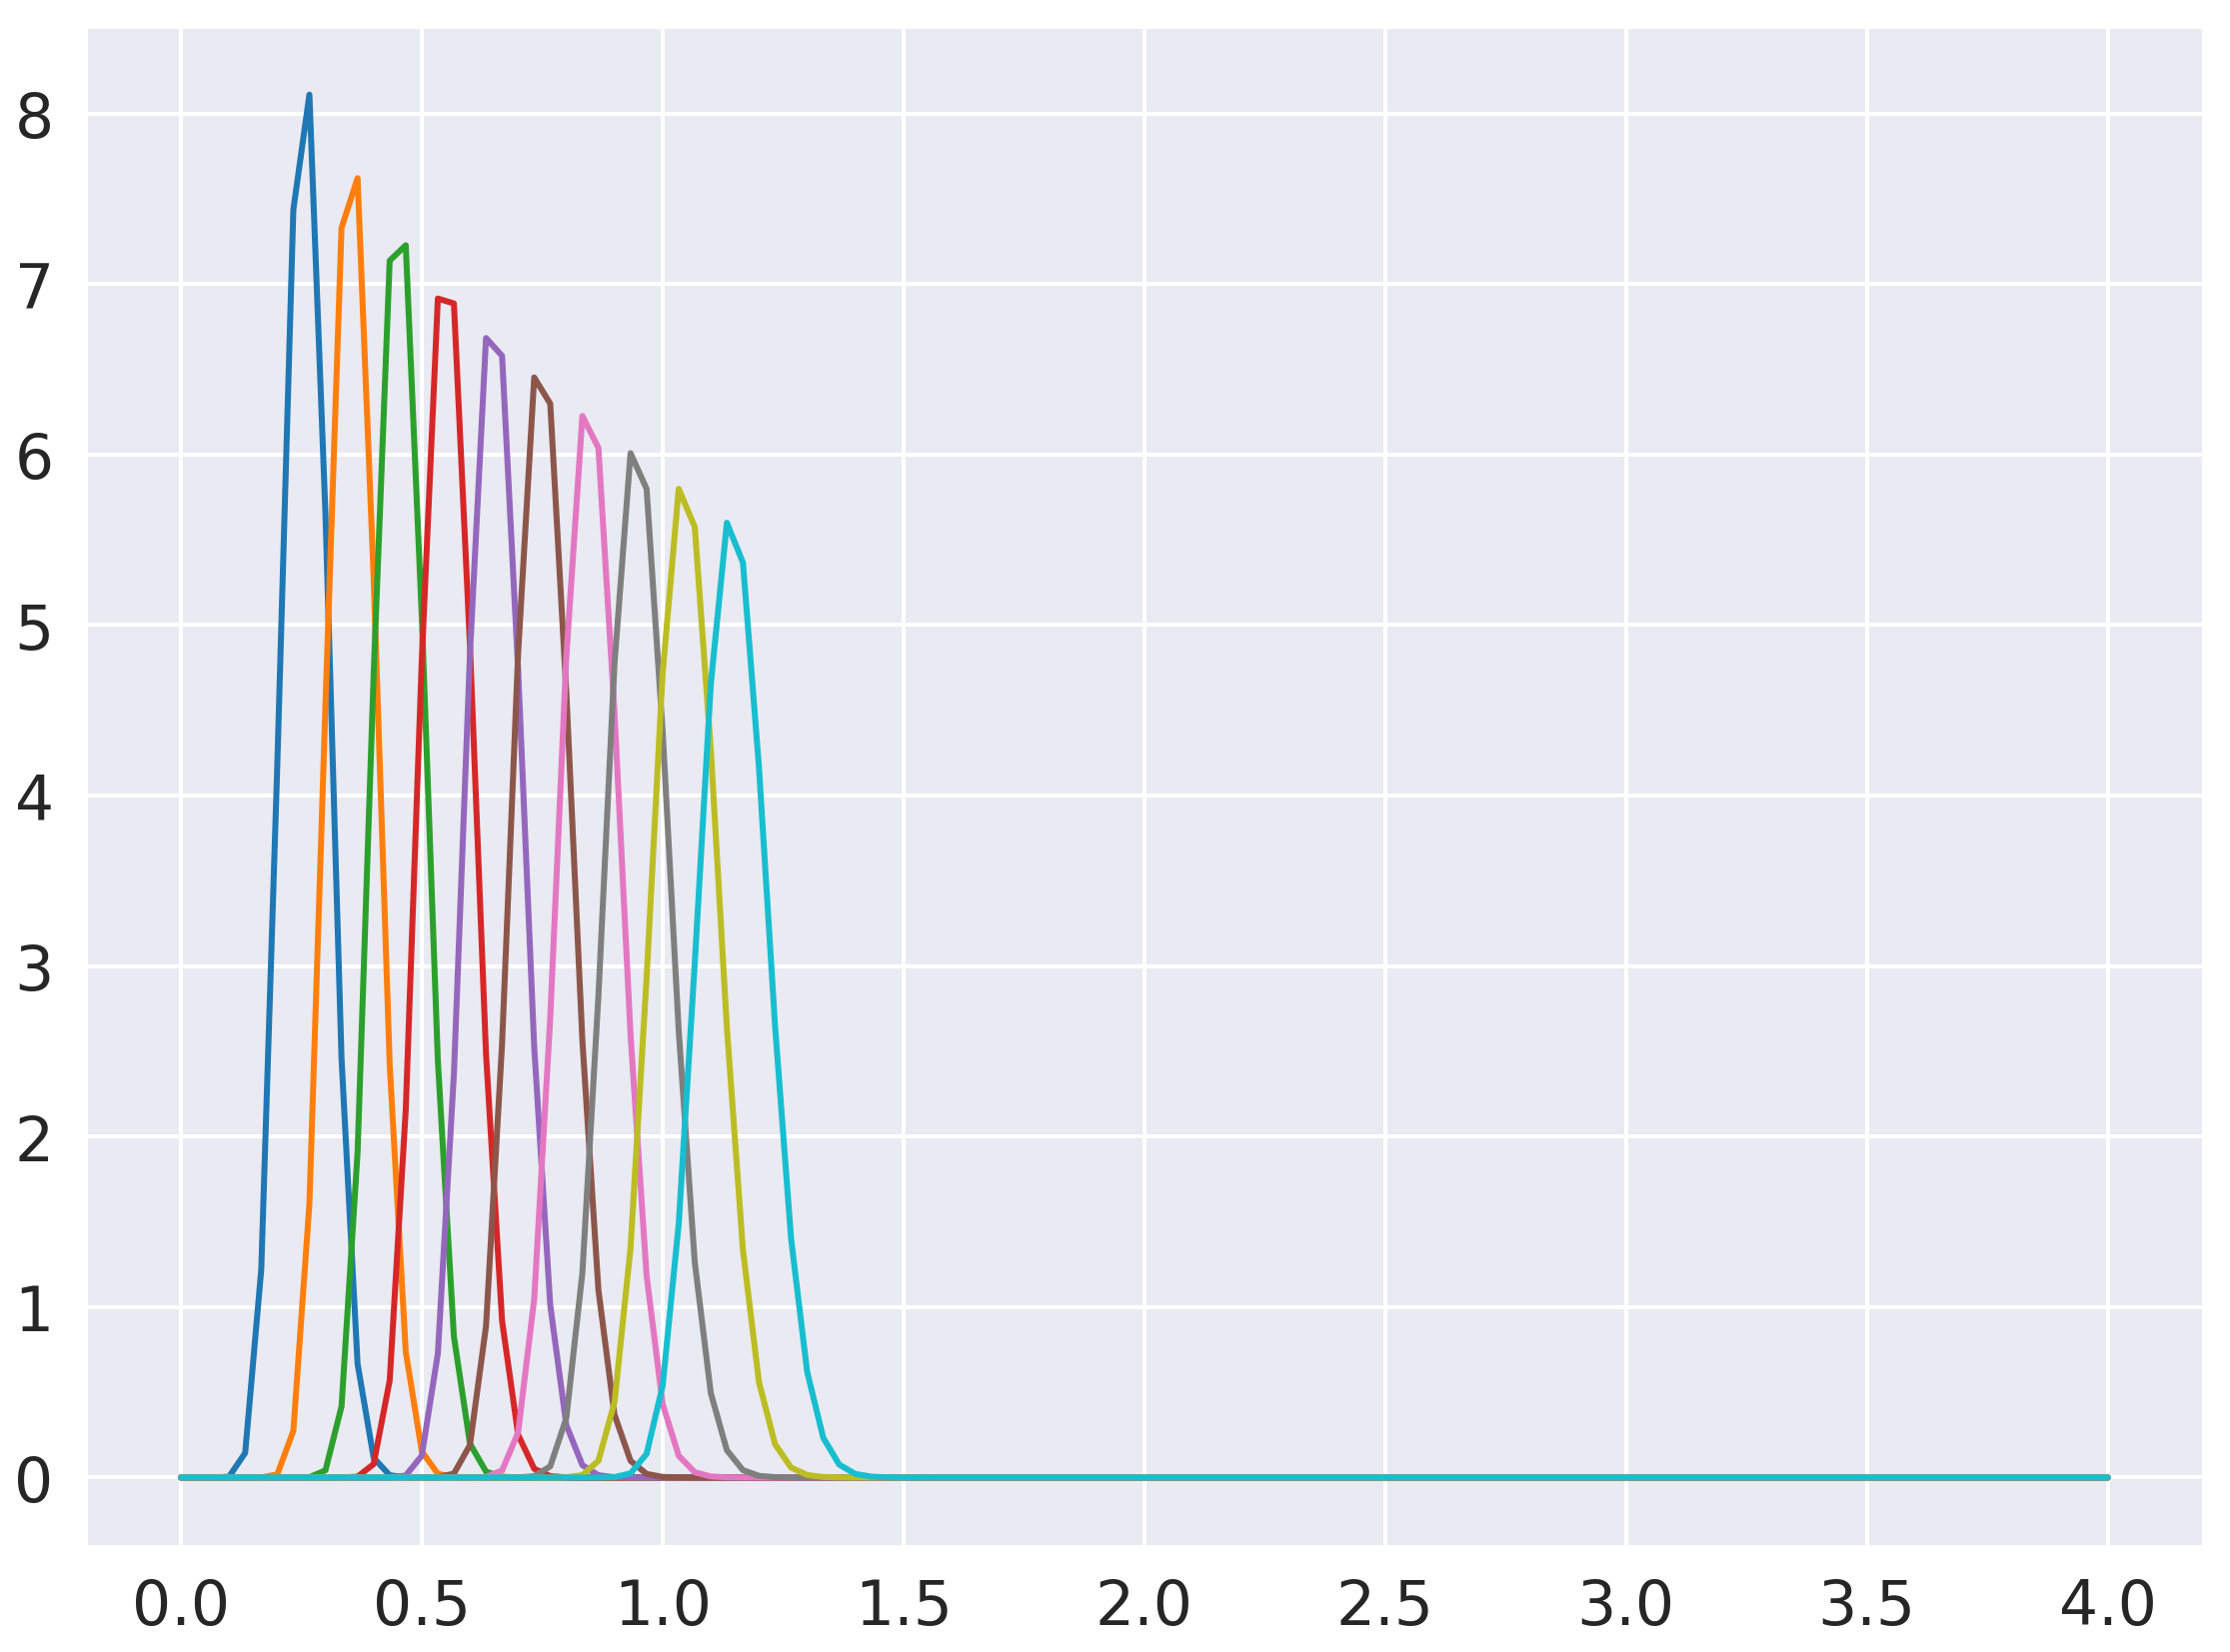

In [139]:
for key in dNdz_dict_lens.keys():
    sns.lineplot(z, dNdz_dict_lens[key], markers=False)

# Getting observables from CCL

In [102]:
cosmo = ccl.Cosmology(Omega_c=0.222, Omega_b=0.045, h=0.71, sigma8=0.806, n_s=0.963)
pprint(cosmo_fid)

pyccl.Cosmology(Omega_c=0.222, Omega_b=0.045, h=0.71, n_s=0.963, sigma8=0.806, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, m_nu=0.0, mnu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_class', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


## Shear-shear correlation function

In [169]:
ell = np.arange(2, 2000)
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz_dict_lens[0.1+0.2]))
lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz_dict_lens[0.5]))
nc = ccl.NumberCountsTracer(cosmo, False, dndz=(z, dNdz_dict_source[0.9]), bias=(z, np.ones(len(z))))
cls = ccl.angular_cl(cosmo, lens1, lens1, ell)

In [128]:
theta_deg = np.logspace(-1, 1, 40)
xi_plus = ccl.correlation(cosmo, ell, cls, theta_deg, corr_type='L+', method='FFTLog')

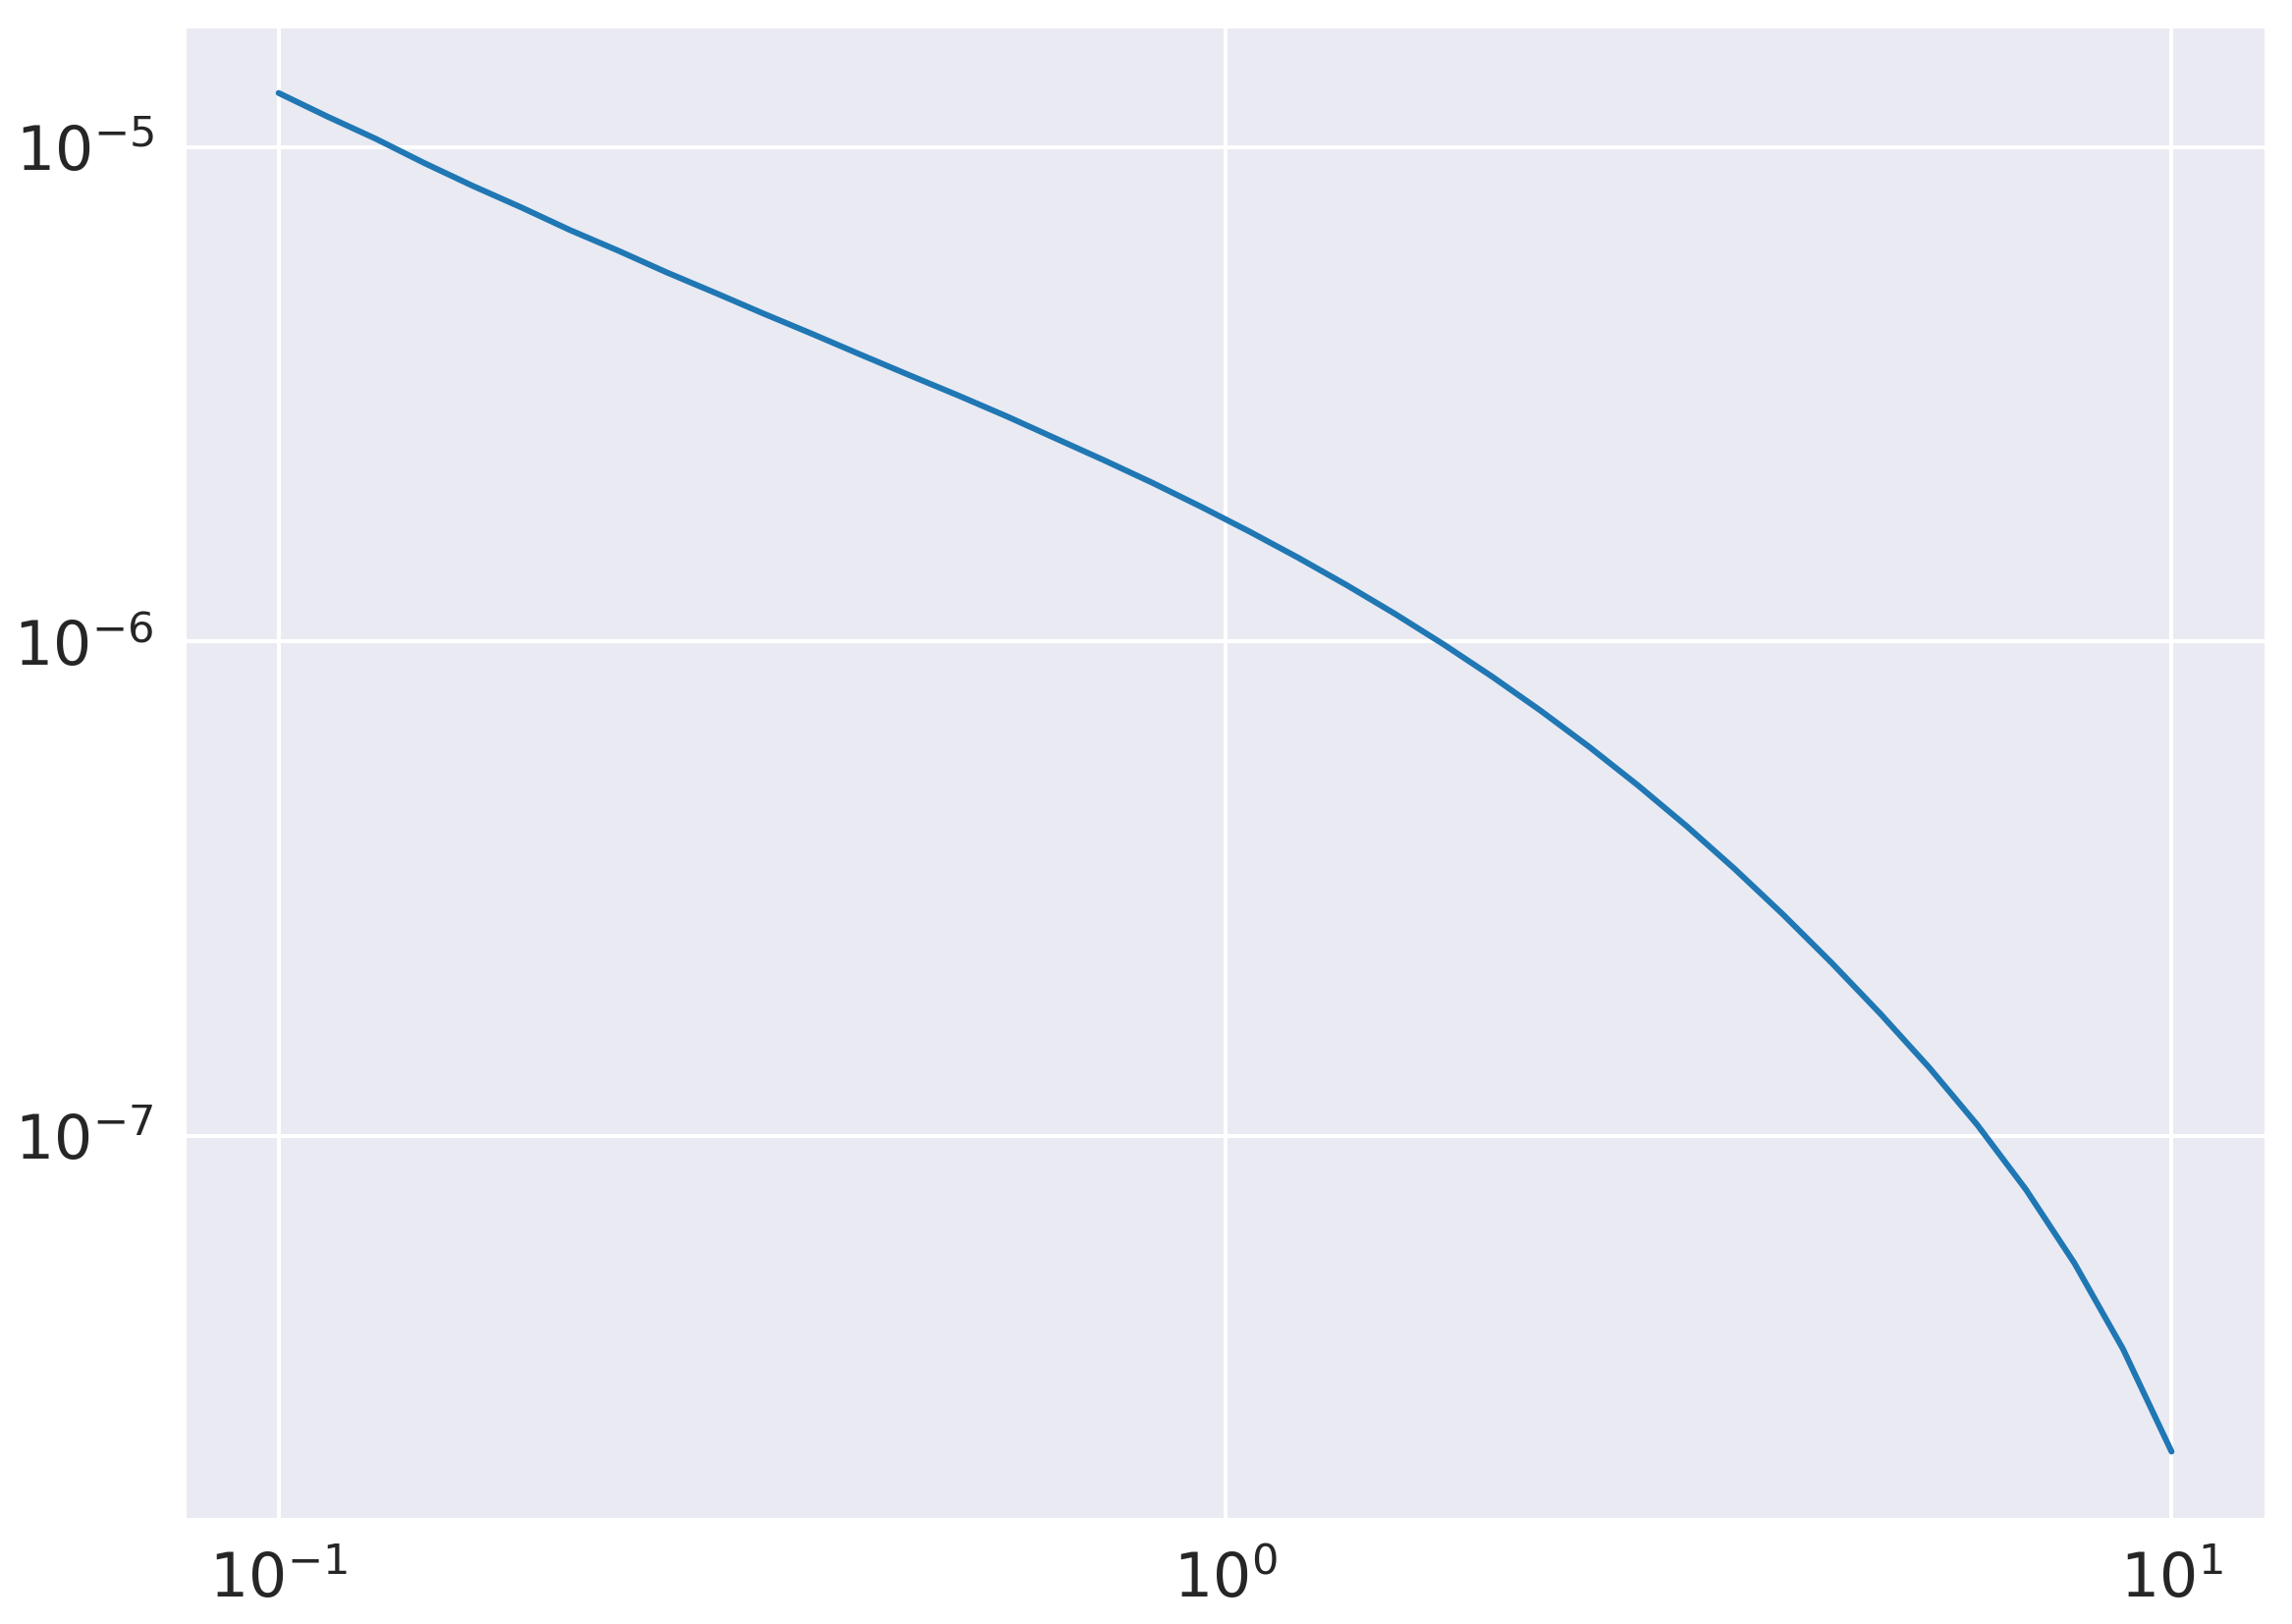

In [134]:
plt.plot(theta_deg, xi_plus)
plt.xscale('log')
plt.yscale('log')

# Getting observables from Cosmosis/Firecrown

In [142]:
fc.run_cosmosis?

Signature: fc.run_cosmosis(config, data)
Docstring:
Run CosmoSIS on the problem.

This requires the following parameters 'sampler' section
of the config:

  sampler - name of sampler to use, e.g. emcee, multinest, grid, ...
  output - name of file to save to

Parameters
----------
config : dict
    Configuration info, usually read directly from the YAML file

data : dict
    The result of calling `firecrown.config.parse` on an input YAML
    config.
File:      ~/.local/lib/python3.6/site-packages/firecrown/cosmosis/run.py
Type:      function


## Writing out config.yaml file for firecrown to call cosmosis on

### Write out n(z) to csv

In [156]:
df = pd.DataFrame({'z': z, 'nz': dNdz_dict_lens[0.1+0.2]})
df.to_csv('pz.csv', index=False)

### Create a toy data vectors

In [170]:
tracers = [lens1, lens2, nc]

dv = []
ndv = []

for i in range(len(tracers)):
    for j in range(i, len(tracers)):
        pell = ccl.angular_cl(cosmo, tracers[i], tracers[j], ell)
        npell = pell + np.random.normal(size=pell.shape[0]) * 0.01 * pell

        df = pd.DataFrame({'l': ell, 'cl': npell})
        df.to_csv('cl{}{}.csv'.format(i, j), index=False)
        dv.append(pell)
        ndv.append(npell)


### Create a fake covariance matrix

In [ ]:
dv = np.concatenate(dv, axis=0)
ndv = np.concatenate(ndv, axis=0)

nelts = len(tracers) * (len(tracers) + 1) // 2

cov = np.identity(len(pell) * nelts)

for i in range(len(dv)):
    cov[i, i] *= (0.01 * dv[i]) ** 2
_i = []
_j = []
_val = []
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        _i.append(i)
        _j.append(j)
        _val.append(cov[i, j])
df = pd.DataFrame({'i': _i, 'j': _j, 'cov': _val})
df.to_csv('cov.csv', index=False)



### Write out .yaml file

In [ ]:
1

In [177]:
%%file config.yaml

parameters:
  Omega_k: 0.0
  Omega_c: 0.27
  Omega_b: 0.045
  h: 0.67
  n_s: 0.96
  sigma8: 0.8
  w0: -1.0
  wa: 0.0
  src0_delta_z: 0.0
  src1_delta_z: 0.0
two_point:
  module: firecrown.ccl.two_point
  sources:
    src0:
      kind: WLSource
      nz_data: pz.csv
      has_intrinsic_alignment: False
      systematics:
        - pz_delta_0
  systematics:
    pz_delta_0:
      kind: PhotoZShiftBias
      delta_z: src0_delta_z
  likelihood:
    kind: ConstGaussianLogLike
    data: cov.csv
    data_vector:
      - cl_src0_src0
      - cl_src0_src1
      - cl_src1_src1
  statistics:
    cl_src0_src0:
      sources: ['src0', 'src0']
      kind: 'cl'
      data: cl00.csv
    cl_src0_src1:
      sources: ['src0', 'src1']
      kind: 'cl'
      data: cl01.csv
    cl_src1_src1:
      sources: ['src1', 'src1']
      kind: 'cl'
      data: cl11.csv


Overwriting config.yaml


## Run cosmosis

In [178]:
config, data = fc.parse('config.yaml')

In [180]:
config

{'parameters': {'Omega_k': 0.0,
  'Omega_c': 0.27,
  'Omega_b': 0.045,
  'h': 0.67,
  'n_s': 0.96,
  'sigma8': 0.8,
  'w0': -1.0,
  'wa': 0.0,
  'src0_delta_z': 0.0,
  'src1_delta_z': 0.0},
 'two_point': {'module': 'firecrown.ccl.two_point',
  'sources': {'src0': {'kind': 'WLSource',
    'nz_data': 'pz.csv',
    'has_intrinsic_alignment': False,
    'systematics': ['pz_delta_0']}},
  'systematics': {'pz_delta_0': {'kind': 'PhotoZShiftBias',
    'delta_z': 'src0_delta_z'}},
  'likelihood': {'kind': 'ConstGaussianLogLike',
   'data': 'cov.csv',
   'data_vector': ['cl_src0_src0', 'cl_src0_src1', 'cl_src1_src1']},
  'statistics': {'cl_src0_src0': {'sources': ['src0', 'src0'],
    'kind': 'cl',
    'data': 'cl00.csv'},
   'cl_src0_src1': {'sources': ['src0', 'src1'],
    'kind': 'cl',
    'data': 'cl01.csv'},
   'cl_src1_src1': {'sources': ['src1', 'src1'],
    'kind': 'cl',
    'data': 'cl11.csv'}}}}

In [181]:
data

{'parameters': {'Omega_k': 0.0,
  'Omega_c': 0.27,
  'Omega_b': 0.045,
  'h': 0.67,
  'n_s': 0.96,
  'sigma8': 0.8,
  'w0': -1.0,
  'wa': 0.0,
  'src0_delta_z': 0.0,
  'src1_delta_z': 0.0},
 'two_point': {'data': {'statistics': {'cl_src0_src0': <firecrown.ccl.statistics.two_point.TwoPointStatistic at 0x2b72f68ad710>,
    'cl_src0_src1': <firecrown.ccl.statistics.two_point.TwoPointStatistic at 0x2b72f68ad978>,
    'cl_src1_src1': <firecrown.ccl.statistics.two_point.TwoPointStatistic at 0x2b72f6981be0>},
   'sources': {'src0': <firecrown.ccl.sources.sources.WLSource at 0x2b750b5fabe0>},
   'likelihood': <firecrown.ccl.likelihoods.gaussian.ConstGaussianLogLike at 0x2b750b5fa2e8>,
   'systematics': {'pz_delta_0': <firecrown.ccl.systematics.pz.PhotoZShiftBias at 0x2b72f68ad4a8>}},
  'eval': <function firecrown.ccl.two_point.compute_loglike(*, cosmo, parameters, data)>}}

In [ ]:
cosmosis_results = fc.run_cosmosis(config, data)